In [ ]:
!pip install cirq
!pip install xlrd

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

     |████████████████████████████████| 389kB 5.0MB/s 
     |████████████████████████████████| 1.5MB 7.5MB/s 
     |████████████████████████████████| 1.3MB 19.4MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


Saving DataPeruzzo.xlsx to DataPeruzzo.xlsx
User uploaded file "DataPeruzzo.xlsx" with length 14313 bytes


In [ ]:
import cirq
import scipy
import unicodedata
import numpy as np
import statistics
import matplotlib.pyplot as plt
import xlrd

## Basic Definitions

In [ ]:
# Define necessary Pauli operators (two-dimensional) as matrices
pauliX=np.array([[0,1],
                 [1,0]],
                dtype=complex)
pauliZ=np.array([[1,0],
                 [0,-1]],
                dtype=complex)

# Define dictionary of necessary Pauli operators (four-dimensional) as matrices
operator={
    "II": np.kron(np.identity(2),np.identity(2)),
    "IX": np.kron(np.identity(2),pauliX),
    "IZ": np.kron(np.identity(2),pauliZ),
    "XI": np.kron(pauliX,np.identity(2)),
    "XX": np.kron(pauliX,pauliX),
    "XZ": np.kron(pauliX,pauliZ),
    "ZI": np.kron(pauliZ,np.identity(2)),
    "ZX": np.kron(pauliZ,pauliX),
    "ZZ": np.kron(pauliZ,pauliZ)
    }

# Example Hamiltonian, for atomic distance R=90pm
hamiltonian90={
    "II": -3.8505,
    "IX": -0.2288,
    "IZ": -1.0466,
    "XI": -0.2288,
    "XX": +0.2613,
    "XZ": +0.2288,
    "ZI": -1.0466,
    "ZX": +0.2288,
    "ZZ": +0.2356
    }

# Read the data table with the coefficients of Pauli strings for the 
#Hamiltonians of several atomic distances for He-H+
#(article by Peruzzo et al)
directory=r'DataPeruzzo.xlsx'
workbook = xlrd.open_workbook(directory)
    
worksheet = workbook.sheet_by_index(0)

# Store in a list the names of the Pauli strings that appear in the first row
pauliStrings = []

for row in range(worksheet.ncols):
    pauliStrings.append( worksheet.cell_value(0,row) )
    
# Create a list of Hamiltonians as dictionaries from the data, and a list of
#the atomic distances
listOfHamiltonians=[]
listOfRadii=[]

for row in range(1, worksheet.nrows):
    hamiltonian={}
    
    # Append to the list of atomic separations the value in picometers
    listOfRadii.append(100*float(worksheet.cell_value(row,0))) 
    
    # Associate to each Pauli string (key) in the Hamiltonian (dictionary) 
    #its coefficient (value)
    for col in range(1,worksheet.ncols):
        hamiltonian[pauliStrings[col]]=float(worksheet.cell_value(row,col))/2 
        
    # Append the dictionary representing the Hamiltonian to the list of 
    #Hamiltonians
    listOfHamiltonians.append(hamiltonian)
    
########################## Hamiltonian Reorganization #########################

def findSubStrings(mainString,hamiltonian,checked=[]):
    '''
    Arguments: a Pauli string (e.g., "XZ"), a hamiltonian (with Pauli strings
    as keys and their coefficients as values) and a list of 'checked' strings,
    which have already been grouped.
    Returns: a tuple (groupedOperators,checked). The former is a 
    dictionary whose keys are boolean strings representing substrings of the
    main one (e.g. if mainString="XZ", "IZ" would be represented as "01"). 
    groupedOperators includes all the strings in the hamiltonian that are of 
    this form, except for those that were in the 'checked' list passed as an 
    argument, meaning that they are already part of another group of strings
    that only differ by identities. checked, the second element in the 
    returned tuple, is the same list passed as an argument, with extra values
    (the strings that were grouped in this function call).
    '''
    
    groupedOperators={}
    
    # Go through the keys in the dictionary representing the Hamiltonian that 
    #haven't been grouped yet, and find those that only differ from mainString 
    #by identities
    for pauliString in hamiltonian:
        
        if pauliString not in checked:
            # The string hasn't been grouped yet
            
            if(all((op1==op2 or op2=="I") \
                   for op1,op2 in zip(mainString,pauliString))):
                # The string only differs from mainString by identities
                
                # Represent the string as a substring of the main one
                booleanString="".join([str(int(op1==op2)) for op1,op2 in \
                                       zip(mainString,pauliString)])
                    
                # Add the boolean string representing this string as a key to 
                #the dictionary of grouped operators, and associate its 
                #coefficient as its value
                groupedOperators[booleanString]=hamiltonian[pauliString]
                
                # Mark the string as grouped, so that it's not added to any 
                #other group
                checked.append(pauliString)
                
    return (groupedOperators,checked)

def groupHamiltonian(hamiltonian):
    '''
    Arguments: a hamiltonian (with Pauli strings as keys and their coefficients 
    as values).
    Returns: groupedHamiltonian, a dictionary of subhamiltonians, each of 
    which includes Pauli strings that only differ from each other by identities.
    As such, the expectation values of all the strings in each subhamiltonian
    can be calculated from the same measurement array.
    The keys of groupedHamiltonian are the main strings. The values associated
    to them are dictionaries whose keys are boolean strings representing 
    substrings of the respective main string. The values are their 
    coefficients.
    '''
    groupedHamiltonian={}
    checked=[]
    
    # Go through the hamiltonian, starting by the terms that have less
    #identity operators
    for mainString in \
        sorted(hamiltonian,key=lambda pauliString: pauliString.count("I")):
            
        # Call findSubStrings to find all the strings in the dictionary that 
        #only differ from mainString by identities, and organize them as a 
        #dictionary (groupedOperators)
        groupedOperators,checked=findSubStrings(mainString,hamiltonian,checked)
        
        # Use the dictionary as a value for the mainString key in the 
        #groupedHamiltonian dictionary
        groupedHamiltonian[mainString]=groupedOperators
        
        # If all the strings have been grouped, exit the for cycle
        if(len(checked)==len(hamiltonian.keys())):
           break
       
    return(groupedHamiltonian)

############################## State Preparation ##############################

def fromParametersToCoordinates(stateParameters):
    '''
    Arguments: a list containing 6 parameters defining a normalized 2 qubit, 
    state, with the DoF corresponding to the global phase removed.
    Returns: a list containing the 4 complex coordinates of the state in the 
    computational basis.
    '''
    
    # Get the parameters from the input list
    theta0=stateParameters[0]
    theta1=stateParameters[1]
    theta2=stateParameters[2]
    w0=stateParameters[3]
    w1=stateParameters[4]
    w2=stateParameters[5]
    
    # Calculate complex coordinates from parameters
    alpha=np.cos(theta0/2)*np.cos(theta1/2)
    beta=np.cos(theta0/2)*np.sin(theta1/2)*np.exp(w1*1j)
    gamma=np.sin(theta0/2)*np.exp(w0*1j)*np.cos(theta2/2)
    delta=np.sin(theta0/2)*np.exp(w0*1j)*np.sin(theta2/2)*np.exp(w2*1j)
    
    return [alpha,beta,gamma,delta]

def tensorProductToRotationGates(unitaryMatrix0,unitaryMatrix1,qubit0,qubit1,\
                                 keepPhase):
    ''' 
    Arguments: two unitary matrices, two qubits, a boolean keepPhase indicating
    whether global phase should be kept.
    Returns: a circuit composed of single qubit rotation gates, that is 
    equivalent (up to a global phase) to the action of the tensor product of 
    the two matrices. 
    ''' 
    
    # Compute the angles of each rotation from the entries of the matrix
    rz1angle_q0=-np.angle(unitaryMatrix0[0][0])+np.angle(-unitaryMatrix0[0][1])
    ryangle_q0=2*np.arccos(np.abs(unitaryMatrix0[0][0]))
    rz2angle_q0=-np.angle(unitaryMatrix0[0][0])+np.angle(unitaryMatrix0[1][0])
    
    rz1angle_q1=-np.angle(unitaryMatrix1[0][0])+np.angle(-unitaryMatrix1[0][1])
    ryangle_q1=2*np.arccos(np.abs(unitaryMatrix1[0][0]))
    rz2angle_q1=-np.angle(unitaryMatrix1[0][0])+np.angle(unitaryMatrix1[1][0])
    
    if keepPhase:
        gp0=np.angle(unitaryMatrix0[0][0])+(rz1angle_q0+rz2angle_q0)/2
        gp1=np.angle(unitaryMatrix1[0][0])+(rz1angle_q1+rz2angle_q1)/2
        gp=gp0+gp1
    
    # Create the necessary rotation gates
    r1_q0=cirq.rz(rz1angle_q0+rz1angle_q1)
    r2_q0=cirq.ry(ryangle_q0)
    r3_q0=cirq.rz(rz2angle_q0)
    
    r1_q1=cirq.ry(ryangle_q1)
    r2_q1=cirq.rz(rz2angle_q1)
    
    '''
    Reconstruct matrix from the calculated angles.
    Just for debbugging.
    if(keepPhase):
        
        # Reconstruct matrix acting on qubit 0
        u00=np.cos(ryangle_q0/2)*np.exp(-1j*((rz1angle_q0+rz2angle_q0)/2-gp0))
        u10=np.sin(ryangle_q0/2)*np.exp(-1j*((rz1angle_q0-rz2angle_q0)/2-gp0))
        u01=-np.sin(ryangle_q0/2)*np.exp(-1j*((-rz1angle_q0+rz2angle_q0)/2-gp0))
        u11=np.cos(ryangle_q0/2)*np.exp(-1j*((-rz1angle_q0-rz2angle_q0)/2-gp0))
        print(u00,u01,u10,u11)
        print(unitaryMatrix0)
        
        # Reconstruct matrix acting on qubit 1
        v00=np.cos(ryangle_q1/2)*np.exp(-1j*((rz1angle_q1+rz2angle_q1)/2-gp1))
        v10=np.sin(ryangle_q1/2)*np.exp(-1j*((rz1angle_q1-rz2angle_q1)/2-gp1))
        v01=-np.sin(ryangle_q1/2)*np.exp(-1j*((-rz1angle_q1+rz2angle_q1)/2-gp1))
        v11=np.cos(ryangle_q1/2)*np.exp(-1j*((-rz1angle_q1-rz2angle_q1)/2-gp1))
        print(v00,v01,v10,v11)
        print(unitaryMatrix1)
    '''
    
    yield [r1_q0(qubit0)]
    yield [r2_q0(qubit0),r1_q1(qubit1)]
    yield [r3_q0(qubit0),r2_q1(qubit1)]
    if keepPhase:
        yield cirq.MatrixGate(np.identity(2)*np.exp(1j*gp)).on(qubit0)
    
def schmidtDecompositionCircuit(stateMatrix,qubits):
    ''' 
    Arguments: a 2x2 matrix representing a two qubit state, the element in 
    position i,j being the coefficient of |ij>, and a pair of qubits to be 
    prepared in that state.
    Returns: a recipe to prepare the state, as a tuple. "gates" is the list of
    gates to be applied first to create the necessary amount of entanglement, 
    and unitary0, unitary1 are the single qubit unitary matrices representing 
    the operations that should be applied  on the qubits (in position 0 and 1 
    respectively) afterwards.
    ''' 
    
    # Get the SVD decomposition
    unitary0, s, unitary1= np.linalg.svd(stateMatrix)
    
    # Create operations to get s[0]|00>+s[1]|11> from |00>
    rotation=cirq.ry(2*np.arccos(np.abs(s[0])))
    gates=[rotation(qubits[0]),cirq.CNOT(qubits[0],qubits[1])]
    
    return (gates,unitary0,np.matrix.transpose(unitary1))

def statePreparationGates(stateParameters,qubits,keepPhase=False):
    '''  
    Returns: gates to be applied on two qubits to prepare a certain state from 
    |00>.
    Arguments: parameters defining  the two qubit state, and the qubits to be 
    prepared on this state.
    ''' 
    
    # Get the state coordinates
    alpha,beta,gamma,delta=fromParametersToCoordinates(stateParameters)
    
    # Write the state coordinates as a 2x2 matrix
    matrix=np.array([[alpha,beta],
                    [gamma,delta]],
                    dtype=complex)

    # Get the gates to be applied first, and the unitary single qubit matrices
    #to be applied second to prepare the state
    gates,unitary0,unitary1=schmidtDecompositionCircuit(matrix,qubits)
    
    yield gates
    yield tensorProductToRotationGates(unitary0,unitary1,qubits[0],qubits[1],\
                                       keepPhase)

##################### Experimental Expectation Estimation #####################


def measureExpectation(mainString,subHamiltonian,repetitions,stateParameters):
    ''' 
    Returns: the expectation value of subHamiltonian, obtained by using the
    CIRQ simulator.
    Arguments: the main Pauli string (that defines the circuit that will be 
    used), subHamiltonian (a dictionary whose keys are boolean strings
    representing substrings of the main one, and whose values are the 
    respective coefficients), the number of repetitions to be performed, the 
    list of parameters defining the state in which to obtain the expectation 
    value.
    ''' 
    
    # Initialize qubits and circuit.
    n=2
    qubits=cirq.LineQubit.range(n)
    circuit=cirq.Circuit()
    
    # Append to the circuit the gates that prepare the state corresponding to
    #the received parameters.
    circuit.append(statePreparationGates(stateParameters,qubits))
    
    # Append necessary rotations and measurements for each qubit.
    for i in range(n):
        op=mainString[i]
        
        # Rotate qubit i to the X basis if that's the desired measurement.
        if (op=="X"):
            circuit.append(cirq.H(qubits[i]))
            
        # Should include rotation to the Y basis if the Hamiltonian includes 
        #Pauli strings with Y matrix.
        #if (op=="Y")...
            
        # Measure qubit i in the computational basis, unless operator is I.
        if (op!="I"):
            circuit.append(cirq.measure(qubits[i],key=str(i)))
            
    # Sample the desired number of repetitions from the circuit, unless
    #there are no measurements (identity term).
    if (mainString!="II"):
        s=cirq.Simulator()
        results=s.run(circuit,repetitions=repetitions)
    
    # For each substring, initialize the sum of all measurements as zero
    total={}
    for subString in subHamiltonian:
        total[subString]=0
    
    # Calculate the expectation value of each Pauli string by averaging over  
    #all the repetitions
    for j in range(repetitions):
        meas={}
        
        # Initialize the measurement in repetition j for all substrings
        for subString in subHamiltonian:
            meas[subString]=1
        
        # Go through the measurements on all the qubits
        for i in range(n):
            
            if (mainString[i]!="I"):
                # There's a measurement associated with this qubit
                
                # Use this single qubit measurement for the calculation of the
                #measurement of each full substring in this repetition. If the
                #substring has a "0" in the position corresponding to this
                #qubit, the operator associated is I, and the measurement
                #is ignored (raised to the power of 0)
                for subString in subHamiltonian:
                    meas[subString]=meas[subString]*((1-2*results.data[str(i)][j])\
                                                     **int(subString[i]))
                        
        # Add this measurement to the total, for each string
        for subString in subHamiltonian:
            total[subString]+=meas[subString]
        
    totalExpectationValue=0
    
    # Calculate the expectation value of the subHamiltonian, by multiplying
    #the expectation value of each substring by the respective coefficient
    for subString in subHamiltonian:
        
        # Get the expectation value of this substring by taking the average
        #over all the repetitions
        expectationValue=total[subString]/repetitions
        
        # Add this value to the total expectation value, weighed by its 
        #coefficient
        totalExpectationValue+=expectationValue*subHamiltonian[subString]
    
    return(totalExpectationValue)

count=0
trackOptimization=False

def experimentalExpectationEstimation(stateParameters,hamiltonian,repetitions):
    ''' 
    Returns: the experimental energy expectation in a given state.
    Arguments: a list of 6 parameters defining the state in which to obtain the 
    expectation value, a dictionary with the coefficients of each Pauli string
    term in the Hamiltonian, the number of repetitions to be used to calculate 
    the expectation value of each string.
    ''' 
    
    # Print the percentage of the maximum number of function evaluations that 
    #has been used so far in the classical optimization, if it's a multiple of
    #10% (to inform on the stage of the optimization process).
    global count, trackOptimization
    if(trackOptimization):
        if (count%(300/10)==0):
            print(round(count/(300/100)),"%",sep='')
        count=count+1

    groupedHamiltonian=groupHamiltonian(hamiltonian)

    experimentalEnergyExpectation=0
    
    # Obtain experimental expectation value for each necessary Pauli string by
    #calling the measureExpectation function, and perform the necessary weighed
    #sum to obtain the energy expectation value.
    for mainString in groupedHamiltonian:
         
        expectationValue=measureExpectation(mainString,\
                                            groupedHamiltonian[mainString],\
                                                repetitions,stateParameters)
        experimentalEnergyExpectation+=expectationValue

    return experimentalEnergyExpectation
    
##################### Theoretical Expectation Estimation #####################

def theoreticalExpectationEstimation(stateParameters,hamiltonian):
    ''' 
    Returns: the theoretical energy expectation in a given state.
    Arguments: a list with the 6 parameters defining the state in which to 
    obtain the expectation value, a dictionary with the coefficients of each
    Pauli string term in the Hamiltonian.
    ''' 

    theoreticalEnergyExpectation=0
    
    # Obtain the theoretical expectation value for each Pauli string in the
    #Hamiltonian by matrix multiplication, and perform the necessary weighed
    #sum to obtain the energy expectation value.
    for pauliString in hamiltonian:
    
        alpha,beta,gamma,delta=fromParametersToCoordinates(stateParameters)
        
        ket=np.array([alpha,beta,gamma,delta],dtype=complex)
        bra=np.conj(ket)
        
        expectationValue=np.real\
            (np.dot(bra,np.matmul(operator[pauliString],ket)))
        
        theoreticalEnergyExpectation+=\
            hamiltonian[pauliString]*expectationValue
            
    return theoreticalEnergyExpectation

############################# Complete Algorithm #############################

def vqe(initialParameters,hamiltonian,repetitions=1000,\
        optTolerance=(0.07,0.13),delta=0.7,simulate=True):
    ''' 
    Returns: an OptimizeResult object consisting of the result of attempting to
    minimize the expectation value of the energy by using the VQE algorithm.
    Arguments: a list with the initial guess for the 6 parameters, the 
    Hamiltonian as a dictionary whose keys are Pauli strings and values the 
    respective coefficients, the number of repetitions for the expectation 
    estimation, a tuple optTolerance=(fatol,xatol) for the optimization using
    Nelder Mead, the parameter delta which will be used along with 
    initialParameters to create the initial simplex, and a boolean flag 
    'simulate' that should be set to False to otimize the theoretical 
    calculation of the energy, with no circuit simulations (for debugging).
    Default values for optTolerance, delta are optimized for default 
    repetitions.
    ''' 
    global trackOptimization
    
    # Choose maximum number of function evaluations for the optimization
    # A lower number seems to work better when running the CIRQ simulator
    if(simulate):
        maxfev=300
    else:
        maxfev=1000
        
    fatol,xatol=optTolerance
    
    dim=len(initialParameters)
    initialSimplex=np.array([initialParameters,]*(dim+1))
    
    for i in range(dim):
        initialSimplex[i+1][i]+=delta
    
    # Select the options for the optimization
    options={
        #"disp": True,
        "maxfev": maxfev, # Maximum function evaluations
        "fatol": fatol, # Acceptable absolute error in f for convergence
        "xatol": xatol, # Acceptable absolute error in xopt for convergence
        "adaptive": True,
        "initial_simplex": initialSimplex
        }
    # Choose whether to print the number of function evaluations as a 
    #percentage of the maximum allowed to inform on the stage of the 
    #optimization
    trackOptimization=False
    # Optimize the results from the CIRQ simulation
    if(simulate):
        optResults=scipy.optimize.minimize(experimentalExpectationEstimation,\
                                initialParameters,\
                                (hamiltonian,repetitions),\
                                method='Nelder-Mead',options=options)
                     
    # Optimize the results from theoretical computation
    else:
        optResults=scipy.optimize.minimize(theoreticalExpectationEstimation,\
                                initialParameters,(hamiltonian),\
                                    method='Nelder-Mead',
                                    options=options)
    trackOptimization=False

    ''' COBYLA
    # Optimize the results from the CIRQ simulation
    if(simulate):
        optResults=scipy.optimize.minimize(experimentalExpectationEstimation,\
                                initialParameters,\
                                (hamiltonian,repetitions),\
                                method='COBYLA')
                     
    # Optimize the results from theoretical computation
    else:
        optResults=scipy.optimize.minimize(theoreticalExpectationEstimation,\
                                initialParameters,(hamiltonian),\
                                method='COBYLA')
    '''
    
    # Choose whether to print the results, for testing.
    printResults=False
    
    if(printResults):
        # Print final parameters, obtained from optimization
        for i in range(6):
            
            if i<3:
                print(unicodedata.lookup("GREEK SMALL LETTER THETA"),i,": ",\
                      sep="",end="")
            else:
                print("w",i-3,": ",sep="",end="")
        
            # Bring parameters to [0,2pi] interval
            optimizedParameter=optResults.x[i]/np.pi
            while (optimizedParameter<0):
                optimizedParameter=optimizedParameter+2
            while (optimizedParameter>2):
                optimizedParameter=optimizedParameter-2
                
            print(optimizedParameter,unicodedata.lookup("GREEK SMALL LETTER PI")\
                  ,sep="")
   
    return optResults

############################## Testing Functions ##############################

def statePreparationMatrix(stateParameters):
    '''  
    Returns: a matrix to prepare a certain 2 qubit state from |00>.
    Arguments: a list containing the six parameters that define the state.
    Just for debugging.
    ''' 
    
    # Get value of parametrized state coordinates
    alpha,beta,gamma,delta=fromParametersToCoordinates(stateParameters)
    
    # Create non-unitary matrix with the desired first column
    matrix=np.array([[alpha,1,0,0],
                     [beta,0,1,0],
                     [gamma,0,0,1],
                     [delta,0,0,0]],
                    dtype=complex)
    
    # Apply Gram-Schmidt process to create unitary matrix with
    #alpha, beta, gamma, delta as elements of the first column
    for i in range(1, len(matrix)):
        col_i = matrix[:, i]
        for j in range(0, i):
            col_j = matrix[:, j]
            t = col_i.dot(np.conj(col_j))
            col_i = col_i - t * col_j
        matrix[:, i] = col_i/np.linalg.norm(col_i)
        
    return matrix

def testExpectationEstimation(repetitions,hamiltonian):
    '''
    Returns: a tuple with the error and the standard deviation of the quantum 
    #expectation estimation using the CIRQ simulator (taking the average over
    the results for 10 random states, 100 QEE runs in each).
    Arguments: the number of repetitions used in QEE.
    '''
        
    stdList=[]
    errorList=[]
    
    # Calculate standard deviation and error for 10 random states
    for _ in range(10):
        
        # Generate list of 6 parameters defining a random 2 qubit state 
        theta0=np.pi*np.random.rand()
        theta1=np.pi*np.random.rand()
        theta2=np.pi*np.random.rand()
        w0=2*np.pi*np.random.rand()
        w1=2*np.pi*np.random.rand()
        w2=2*np.pi*np.random.rand()
        stateParameters=[theta0,theta1,theta2,w0,w1,w2]
        
        # Obtain the theoretical value for the energy
        theoreticalEnergyExpectation=theoreticalExpectationEstimation\
            (stateParameters,hamiltonian)
        
        expectationList=[]
        
        # Obtain the experimental value for the energy in 100 QEE runs
        for _ in range(100):
                    
            # Test the experimental energy expectation against the theoretical 
            #value
            experimentalEnergyExpectation=experimentalExpectationEstimation\
                (stateParameters,hamiltonian,repetitions)
            
            expectationList.append(experimentalEnergyExpectation)
            
        # Append to the error list the average difference between 
        #experimental and theoretical energy over the 100 runs
        error=np.mean(np.abs(expectationList-theoreticalEnergyExpectation))
        errorList.append(error)
        
        # Append to the standard deviation list the standard deviation of the
        #100 runs
        stdList.append(np.std(expectationList))
    
    # Return the error and standard deviation estimated by taking the average
    #for the 10 random states
    avError=np.mean(errorList)
    avSTD=np.mean(stdList)
    
    return (avError,avSTD)

def pauliStringSTD(pauliString,repetitions):
    '''
    Returns: the standard deviation associated with the expectation value of a 
    given Pauli string (taking the average over the results for 10 random 
    states, 100 QEE runs in each).
    Arguments: the Pauli string in question, and the number of repetitions for 
    QEE.
    '''

    stdList=[]
    
    # Calculate standard deviation for 10 random states
    for _ in range(10):
        
        # Generate list of 6 parameters defining a random 2 qubit state 
        theta0=np.pi*np.random.rand()
        theta1=np.pi*np.random.rand()
        theta2=np.pi*np.random.rand()
        w0=2*np.pi*np.random.rand()
        w1=2*np.pi*np.random.rand()
        w2=2*np.pi*np.random.rand()
        stateParameters=[theta0,theta1,theta2,w0,w1,w2]
        
        # Get the expectation estimation for the Pauli string in the same state
        #in 100 different runs
        expectationList=[]
        for _ in range(100):
                    
            experimentalExpectation=measureExpectation\
                (pauliString,{"11":1},repetitions,stateParameters)
            
            expectationList.append(experimentalExpectation)
        
        # Add the standard deviation resulting from this state to the list 
        stdList.append(np.std(expectationList))
        
    # Return the average of the standard deviation over the 10 different 
    #states
    return np.mean(stdList)

def dictOfSTD(repetitions,listOfPauliStrings):
    '''
    Returns: a dictionary of the standard deviation associated with the 
    expectation value of multiple Pauli strings, obtained via the CIRQ 
    simulator.
    Arguments: the number of repetitions to be used in obtaining the 
    expectation value, a list containing the Pauli strings whose standard 
    deviation will be calculated.
    '''
    
    STDDictionary={}
    
    for pauliString in listOfPauliStrings:
        STDDictionary[pauliString]=pauliStringSTD(pauliString,repetitions)
        
    return STDDictionary
    

def errorPropagation(stdDictionary,hamiltonian):
    '''
    Returns: the error in the energy expecation value obtained via the CIRQ 
    simulator, resulting from propagating the error associated with the 
    multiple Pauli strings in a given Hamiltonian.
    Arguments: a dictionary containing Pauli strings as keys (at least the ones
    included in the Hamiltonian) and the respective standard deviation as 
    values, and the Hamiltonian as a dictionary of Pauli strings and respective
    coefficients.
    '''
    
    error=0
    
    # Add to the error the variance of each term
    for pauliString in hamiltonian:
        error=error+pow(stdDictionary[pauliString]*hamiltonian[pauliString],2)
            
    # Take the square root to obtain the standard deviation
    error=np.sqrt(error)
    
    return error

def stateFromGates(gates,repetitions,qubits):
    '''
    Returns: a matrix with the element in row i, column j being the probability
    of obtaining state |ij> at the end of a given circuit.
    Arguments: the gates the circuit is comprised of, the number of repetitions 
    to be used to obtain the probabilities, the two qubits the circuit acts on.
    '''
    
    # Create a circuit from the provided gates
    circuit=cirq.Circuit(gates)
    
    # Add measurements and run the circuit
    circuit.append(cirq.measure(qubits[0],key="0"))
    circuit.append(cirq.measure(qubits[1],key="1"))
    s=cirq.Simulator()
    results=s.run(circuit,repetitions=repetitions)
    
    # Calculate the probability of occurence of each computational basis state
    total=np.array([[0,0],[0,0]])
    
    for j in range(repetitions):
        total[results.data[0][j]][results.data[1][j]]=\
            total[results.data[0][j]][results.data[1][j]]+1
            
    probabilityMatrix=total/repetitions
    
    # Return the probabilities organized as a matrix
    return(probabilityMatrix)
    
def testPreparationCircuit(numberOfTests,repetitions):
    '''
    Returns: the average error in probability amplitudes obtained by running
    on CIRQ the circuit created by statePreparationGates to prepare a state, 
    as compared to the actual probabilities, calculated from the wavefunction.
    Arguments: the number of tests over which the average error should be 
    calculated, and the number of repetitions to be used in obtaining the
    experimental probabilities.
    '''
    
    avError=0
    
    # Calculate the average error in probabilities over the desired number of 
    #tests
    for _ in range(numberOfTests):
        
        # Generate 6 random parameters defining a state
        theta0=np.pi*np.random.rand()
        theta1=np.pi*np.random.rand()
        theta2=np.pi*np.random.rand()
        w0=2*np.pi*np.random.rand()
        w1=2*np.pi*np.random.rand()
        w2=2*np.pi*np.random.rand()
        stateParameters=[theta0,theta1,theta2,w0,w1,w2]
    
        # Calculate the theoretical probability matrix (element i,j being 
        #the probability of state |ij>)
        alpha,beta,gamma,delta=fromParametersToCoordinates(stateParameters)
        
        p00=pow(np.abs(alpha),2)
        p01=pow(np.abs(beta),2)
        p10=pow(np.abs(gamma),2)
        p11=pow(np.abs(delta),2)
        
        theoreticalProbabilityMatrix=[[p00,p01],\
                                      [p10,p11]]
        
        # Obtain the experimental probability matrix
        qubits=cirq.LineQubit.range(2)
        experimentalProbabilityMatrix=stateFromGates(statePreparationGates\
                         (stateParameters,qubits),repetitions,qubits)
            
        absoluteErrorMatrix=np.abs(theoreticalProbabilityMatrix\
                                     -experimentalProbabilityMatrix)
            
        avError=avError+np.mean(absoluteErrorMatrix)
        
        return avError/numberOfTests
    
#################################### Tests ####################################

# Set flags to True to execute tests
testStatePreparation = False # State preparation
testQEE = False # Expectation estimation

# Choose the number of random tests to be performed on the state preparation
numberOfTests = 1000

# Choose the number of shots to be used in the state preparation tests
repetitions = 100

# Choose number of shots to be used in the expectation estimation tests
repetitionsQEE = 1000

# Choose hamiltonian to be used in the expectation estimation tests
hamiltonian=hamiltonian90


if testStatePreparation:
    # Test the state preparation circuit

    avError=testPreparationCircuit(numberOfTests,repetitions)

    print("***Testing the state preparation circuit***")
    print("\nBy getting the statistics:")
    print("Completed",numberOfTests,"random tests, with",repetitions,\
          "shots.","\nAverage error in outcome probabilities:",avError)
        
    theta0=np.pi*np.random.rand()
    theta1=np.pi*np.random.rand()
    theta2=np.pi*np.random.rand()
    w0=2*np.pi*np.random.rand()
    w1=2*np.pi*np.random.rand()
    w2=2*np.pi*np.random.rand()
    
    stateParameters=[theta0,theta1,theta2,w0,w1,w2]
    
    # Calculate the theoretical coordinates
    coordinates=fromParametersToCoordinates(stateParameters)
    
    roundedCoordinates=np.ndarray(4,dtype=complex)
    for i,coordinates in enumerate(coordinates):
        roundedCoordinates[i]=(np.round(coordinates,7))
        
    qubits=cirq.LineQubit.range(2)
    circuit=cirq.Circuit()
    circuit.append(statePreparationGates(stateParameters,qubits,keepPhase=True))
    simulator=cirq.Simulator()
    s=simulator.simulate(circuit)
    
    print("\nBy simulating the full wavefunction:")
    print("Actual state coordinates:")
    print(roundedCoordinates)
    print("State resulting from the preparation circuit:")
    print(s.final_state_vector)

if testQEE:
    # Test the expectation estimation
    
    # By testing the full QEE function 
    error,std=testExpectationEstimation(repetitionsQEE,hamiltonian)
    
    print("***Testing the expectation estimation for",repetitionsQEE,"shots***")
    print("By testing the full function:")
    print("Obtained error",error,"and standard deviation",std)
    '''
    # By propagating the error from the individual terms
    listOfPauliStrings=hamiltonian.keys()
    dictOfSTD=dictOfSTD(repetitionsQEE,listOfPauliStrings)
    print("By propagating the error:")
    print("Obtained error",errorPropagation(dictOfSTD,hamiltonian))
    # Propagate error for all points in the bond dissociation curve
    errorList=[]
    
    # Calculate error for all the atomic distances
    for hamiltonian in listOfHamiltonians:
        errorList.append(errorPropagation(dictOfSTD,hamiltonian))
        
    # Plot the results
    plt.title("Error in the Expectation Estimation ("+str(repetitions)+" shots)")
    plt.xlabel("Atomic distance (pm)")
    plt.ylabel("Error (MJ mol$^{-1}$)")
    plt.plot(listOfRadii,errorList)
    '''

################## Functions for the Bond Dissociation Graph ##################

def calculateOverlap(stateCoordinates1,stateCoordinates2):
    '''
    Returns: the overlap between two states.
    Arguments: the coordinates defining each state in the computational basis.
    '''
    
    # Calculate the absolute value of the inner product of the two states
    overlap=np.abs(np.dot(np.conj(stateCoordinates1),stateCoordinates2))
    
    return overlap


def groundStatesFromDiagonalization(listOfHamiltonians):
    '''
    Returns: a tuple with a list of the ground energies and a list of the 
    ground states corresponding to a list of hamiltonians, obtained by exact 
    diagonalization.
    Arguments: the list of hamiltonians as dictionaries.
    '''
    
    exactGroundEnergies=[]
    exactGroundStates=[]
    
    for hamiltonian in listOfHamiltonians:
        hamiltonianMatrix=np.zeros((4,4),dtype=complex)
        
        for pauliString in hamiltonian:
            hamiltonianMatrix+=hamiltonian[pauliString]*operator[pauliString]
            
        w,v = np.linalg.eig(hamiltonianMatrix)
        
        exactGroundEnergies.append((np.amin(w)))
        exactGroundStates.append(v[np.argmin(w)])
        
    return(exactGroundEnergies,exactGroundStates)

def groundStatesFromTheoreticalOptimization(listOfHamiltonians,runs):
    '''
    Returns: a tuple with a list of the ground energies and a list of the 
    ground states corresponding to a list of hamiltonians, obtained by 
    optimizing the value coming from exact calculation of the energy.
    Arguments: the list of hamiltonians as dictionaries, and the number of runs
    over which to take the median (should be an odd number).
    '''
    
    groundEnergies=[]
    groundStates=[]
    
    for hamiltonian in listOfHamiltonians:
            
        optimizationRuns=[]
        stateArray=[]
        
        for i in range(runs):
            
            success=False
            while not success:
                
                theta0=np.pi*np.random.rand()
                theta1=np.pi*np.random.rand()
                theta2=np.pi*np.random.rand()
                w0=2*np.pi*np.random.rand()
                w1=2*np.pi*np.random.rand()
                w2=2*np.pi*np.random.rand()
                
                results=vqe([theta0,theta1,theta2,w0,w1,w2],hamiltonian,\
                            simulate=False)
                success=results.success
                
            groundEnergy=results.fun
            optimizationRuns.append(groundEnergy)
            stateArray.append(results.x)
            
        groundEnergy=statistics.median(optimizationRuns)
        groundEnergies.append(groundEnergy)
        groundState=fromParametersToCoordinates\
            (stateArray[optimizationRuns.index(groundEnergy)])
        groundStates.append(groundState)
        
    return(groundEnergies,groundStates)

def groundStatesFromVQE(listOfHamiltonians,repetitions,runs,dispersion="iqr"):
    '''
    Returns: a tuple with the lists of ground energies from taking the average 
    and the median over multiple VQE runs, and the lists with the ground states 
    and standard deviations from the median.
    They are in correspondence with a list of hamiltonians, and are obtained by 
    optimizing the value coming from QEE on the CIRQ simulator.
    Arguments: the list of hamiltonians as dictionaries, the number of
    repetitions to be used in QEE, the number of runs over which to take
    the median (should be an odd number), the measure of dispersion 
    (IQR (Interquartile Range) or STD (Standard Deviation)).
    '''
    
    global count
     
    medianEnergies=[]
    medianStates=[]
    averageEnergies=[]

    if dispersion.lower() == "std":
      medianStds=[]
    elif dispersion.lower() == "iqr":
      firstQuartile=[]
      thirdQuartile=[]
    else:
      raise ValueError ("Unsupported measure of dispersion (should be std or iqr)")
    
    points=len(listOfHamiltonians)
    
    for (number,hamiltonian) in enumerate(listOfHamiltonians):
        print("*** ",number+1,"/",points," points ***")
            
        energyList=[]
        stateList=[]
        attemptsList=[]
        
        for i in range(runs):
            
            success=False
            attempts=0
            
            while not success:
                
                theta0=np.pi*np.random.rand()
                theta1=np.pi*np.random.rand()
                theta2=np.pi*np.random.rand()
                w0=2*np.pi*np.random.rand()
                w1=2*np.pi*np.random.rand()
                w2=2*np.pi*np.random.rand()
                
                count=0
                results=vqe([theta0,theta1,theta2,w0,w1,w2],hamiltonian,\
                        repetitions=repetitions)
                success=results.success
                
                attempts=attempts+1
                
            attemptsList.append(attempts)
            
            groundState=results.x
            stateList.append(groundState)
            
            # Ignore the energy returned by the optimizer, call QEE on the 
            #parameters instead. The optimizer constantly finds energies
            #below the ground state, because it finds the noisy minimal energy
            #(~ noiseless minimum - error)
            groundEnergy=experimentalExpectationEstimation\
                (groundState,hamiltonian,repetitions)
            energyList.append(groundEnergy)
        
        print("Average number of attempts until success:",\
              int(np.average(attemptsList)))
            
        medianEnergy=statistics.median(energyList)
        medianEnergies.append(medianEnergy)

        if dispersion.lower() == "std":
          medianStds.append(np.std(energyList))
        else: 
          # dispersion.lower() == "iqr"
          firstQuartile.append(medianEnergy-np.percentile(energyList,25))
          thirdQuartile.append(np.percentile(energyList,75)-medianEnergy)
        
        medianState=fromParametersToCoordinates\
            (stateList[energyList.index(medianEnergy)])
        medianStates.append(medianState)
        
        averageEnergy=np.average(energyList)
        averageEnergies.append(averageEnergy)

    if dispersion.lower() == "std":
      return(averageEnergies,medianEnergies,medianStates,medianStds)

    else:
      # dispersion.lower() == "iqr"
      quartiles=(firstQuartile,thirdQuartile)
      return(averageEnergies,medianEnergies,medianStates,quartiles)

## Plots

### Median with error bars for IQR

In [ ]:
########################### Bond Dissociation Graph ###########################

# Set flag to True to generate the graph with the median over several VQE runs,
#and comparison with exact ground energies and exact ground states.
generateMedianGraph=True

# Choose options for the graph. Will only be used if generateMedianGraph is set
#to True.

# Boolean flag to signal the choice of zooming in (or not) on the most
#important region
magnified=True

# Limits of the list of radii whose ground states will be computed. 
# Only used if the flag 'magnified' is set to True.
start=8
end=35

# Number of shots to be used in obtaining the expectation values using the
#CIRQ simulator
repetitions=1000

# Number of runs. If runs>1, the median over all the runs will be taken.
# Should be an odd number.
runs=49

assert(runs % 2 == 1)

# Generate the bond dissociation graph by taking the energy as the median over 
#the desired number of runs, and plot the values from exact diagonalization,
#optimization of the analytical calculation of the energy (if desired), and the
# VQE algorithm, along with the overlap between the exact ground state and the
#one obtained from VQE.
if generateMedianGraph:

    plotTheoreticalVQE=True

    if (magnified):
        # Select desired window of the list of radii
        graphRadii=listOfRadii[(start+1):end]
        graphHamiltonians=listOfHamiltonians[(start+1):end]
    else:
      graphRadii=listOfRadii
      graphHamiltonians=listOfHamiltonians
        
    # Get list of ground energies and states from exact diagonalization
    exactGroundEnergies,exactGroundStates=\
        groundStatesFromDiagonalization(graphHamiltonians)
    
    if plotTheoreticalVQE:
      # Get list of ground energies and states from optimizing the analytically
      #calculated energy
      optimizedGroundEnergies,optimizedGroundStates=\
          groundStatesFromTheoreticalOptimization(graphHamiltonians,runs)
    
    # Get list of ground energies and states from optimizing the energy
    #obtained from simulating the circuit
    groundEnergiesAverage,groundEnergiesVQE,groundStatesVQE,quartiles=\
        groundStatesFromVQE(graphHamiltonians,repetitions,runs)
            
    # Calculate overlaps between the ground state obtained in VQE and the one
    #obtained from exact diagonalization
    overlapList=[]
    for (i,groundStateVQE) in enumerate(groundStatesVQE):
        overlapList.append(calculateOverlap(groundStateVQE,exactGroundStates[i]))
        
    f,axs=plt.subplots(2,figsize=[8,8],constrained_layout=True,sharex=True)
    plt.suptitle('Bond Dissociation Curve of He-H$^+$ ('+str(repetitions)+\
                 ' shots in QEE)')
    
    axs[1].set_xlabel('Atomic Separation (pm)')
    axs[1].set_ylabel('State Overlap')
    
    axs[0].set_ylabel('Ground Energy (MJ mol$^{-1}$)')
    
    if plotTheoreticalVQE:
      theoretical=axs[0].scatter(graphRadii,optimizedGroundEnergies,marker='o',\
                               color='silver')
    if runs != 1:
      experimental=axs[0].errorbar(graphRadii,groundEnergiesVQE,yerr=quartiles,fmt='o',\
                                  capsize=3,color='b')
    else:
      experimental=axs[0].errorbar(graphRadii,groundEnergiesVQE,fmt='o',\
                                  capsize=3,color='b')
    
    exact=axs[0].plot(graphRadii,exactGroundEnergies,color='r')
    
    if plotTheoreticalVQE:
      axs[0].legend([theoretical,experimental,exact[0]],\
                  ['VQE (no noise)','VQE (sampling noise)','Exact Diagonalization'])
      
    else:
      axs[0].legend([experimental,exact[0]],\
                  ['VQE','Exact Diagonalization'])
        
    axs[1].plot(graphRadii,overlapList)
    
    plt.show()

In [ ]:

f,axs=plt.subplots(2,figsize=[8,8],constrained_layout=True,sharex=True)
plt.suptitle('Bond Dissociation Curve of He-H$^+$ ('+str(repetitions)+\
              ' shots in QEE)')

axs[1].set_xlabel('Atomic Separation (pm)')
axs[1].set_ylabel('State Overlap')

axs[0].set_ylabel('Ground Energy (MJ mol$^{-1}$)')

if plotTheoreticalVQE:
  theoretical=axs[0].scatter(graphRadii,optimizedGroundEnergies,marker='o',\
                            color='silver')
if runs != 1:
  experimental=axs[0].errorbar(graphRadii,groundEnergiesVQE,yerr=quartiles,fmt='o',\
                              capsize=3,color='b')
else:
  experimental=axs[0].errorbar(graphRadii,groundEnergiesVQE,fmt='o',\
                              capsize=3,color='b')

exact=axs[0].plot(graphRadii,exactGroundEnergies,color='r')

if plotTheoreticalVQE:
  axs[0].legend([theoretical,experimental,exact[0]],\
              ['VQE (no noise)','VQE (sampling noise)','Exact Diagonalization'])
  
else:
  axs[0].legend([experimental,exact[0]],\
              ['VQE','Exact Diagonalization'])
    
axs[1].plot(graphRadii,overlapList)

plt.show()

### Median vs average

***  1 / 24  points ***
Average number of attempts until success: 1
***  2 / 24  points ***
Average number of attempts until success: 1
***  3 / 24  points ***
Average number of attempts until success: 1
***  4 / 24  points ***
Average number of attempts until success: 1
***  5 / 24  points ***
Average number of attempts until success: 1
***  6 / 24  points ***
Average number of attempts until success: 1
***  7 / 24  points ***
Average number of attempts until success: 1
***  8 / 24  points ***
Average number of attempts until success: 1
***  9 / 24  points ***
Average number of attempts until success: 1
***  10 / 24  points ***
Average number of attempts until success: 1
***  11 / 24  points ***
Average number of attempts until success: 1
***  12 / 24  points ***
Average number of attempts until success: 1
***  13 / 24  points ***
Average number of attempts until success: 1
***  14 / 24  points ***
Average number of attempts until success: 1
***  15 / 24  points ***
Average number of 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


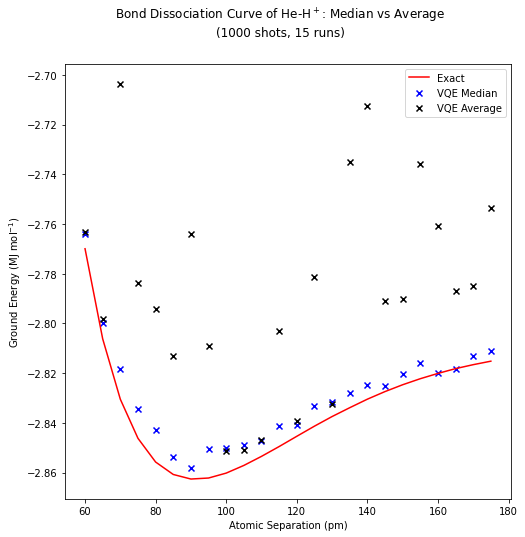

In [ ]:
# Set flag to True to generate the graph with the median vs the average for 
#calculation of the energy through the VQE algorithm.
generateMedianvsAverageGraph=True

# Choose options for the graph. Will only be used if generateGraph is set
#to True.

# Boolean flag to signal the choice of zooming in (or not) on the most
#important region
magnified=True

# Limits of the list of radii whose ground states will be computed. 
# Only used if the flag 'magnified' is set to True.
start=10
end=35

# Number of shots to be used in obtaining the expectation values using the
#CIRQ simulator
repetitions=1000

# Number of runs over which to take the median and the average.
# Should be an odd number.
runs=15

assert(runs % 2 == 1)

# Generate the bond dissociation graph by taking the energy as the median over 
#the desired number of runs, and plot the values from exact diagonalization,
#optimization of the analytical calculation of the energy, and the VQE 
#algorithm, along with the overlap between the exact ground state and the one
#obtained from VQE.
if generateMedianvsAverageGraph:

    if (magnified):
        # Select desired window of the list of radii
        graphRadii=listOfRadii[(start+1):end]
        graphHamiltonians=listOfHamiltonians[start+1:end]
        
    # Get list of ground energies and states from exact diagonalization
    exactGroundEnergies,exactGroundStates=\
        groundStatesFromDiagonalization(graphHamiltonians)
        

    # Get list of ground energies and states from optimizing the energy
    #obtained from simulating the circuit
    groundEnergiesAverage,groundEnergiesMedian,groundStatesVQE,_=\
        groundStatesFromVQE(graphHamiltonians,repetitions,runs)
            
    plt.figure(figsize=[8,8])
    plt.xlabel('Atomic Separation (pm)')
    plt.ylabel('Ground Energy (MJ mol$^{-1}$)')
    plt.suptitle('Bond Dissociation Curve of He-H$^+$: Median vs Average \n('\
                 +str(repetitions)+' shots, '+str(runs)+" runs)")
        
    exact, = plt.plot(graphRadii,exactGroundEnergies,color='r',label='Exact')
    
    median=plt.scatter(graphRadii,groundEnergiesMedian,marker='x',\
                  color='b',label='VQE Median')
        
    average=plt.scatter(graphRadii,groundEnergiesAverage,marker='x',\
                  color='k',label='VQE Average')
        
    plt.legend(handles=[exact,median,average])
    plt.show()